mseloss　回帰問題

In [12]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks'
/content/drive/My Drive/Colab Notebooks/ctorch


フォルダは自分の指定のものに変更してね。

In [17]:
%cd "ctorch210701/MiniCTorch_Prototype"

/content/drive/My Drive/Colab Notebooks/ctorch210701/MiniCTorch_Prototype


サンプルデータ

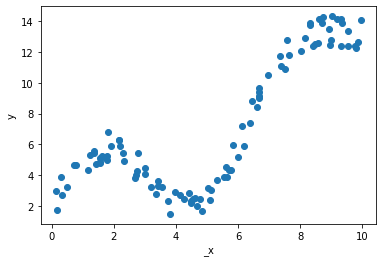

In [18]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2020)

_x = np.random.uniform(0, 10, 100)

x1 = np.sin(_x)
x2 = np.exp(_x / 5)
x = np.stack([x1, x2], axis=1)
y = 3 * x1 + 2 * x2 + np.random.uniform(-1, 1, 100)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(_x, y)
ax.set_xlabel('_x')
ax.set_ylabel('y')
fig.show()

In [19]:
! pip install lark-parser

     |████████████████████████████████| 229 kB 8.8 MB/s 
  Created wheel for lark-parser: filename=lark_parser-0.11.3-py2.py3-none-any.whl size=99739 sha256=a96e1283f2c6c399eef6c7672620e1c71e3dd6f37c8a8db24b942955089df070
  Stored in directory: /root/.cache/pip/wheels/2d/f0/65/7aea47a49de7acac0108aac16a7ee00eb996f872d978feb87e
Successfully built lark-parser


In [20]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

ニューラルネットワークの定義

In [21]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff*diff).sum() / len(diff)
    return y;

class Net(torch.nn.Module):
  def __init__( self, t ):
    super(Net, self).__init__()
    #self.fc1 = nn.Linear(32, 16)
    #self.fc2 = nn.Linear(16, 1)
    self.target = t
  
  def forward(self,x):
    #x = F.relu(self.fc1(x))
    #x = self.fc2(x)
    loss = nn.MSELoss()
    output = loss(x,self.target)
    #output = F.mse_loss(x,self.target)
    return output

In [22]:
def generate_json( json_path, input, target ):

    model = Net( target )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

torch.manual_seed( 1 )

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)

project = 'mse1'
json_path = 'network/' + project +'.json'

model = generate_json( json_path, input, target )

with torch.set_grad_enabled(True):
  output = model( input )
  print(output)
  output.backward()
  print("input",input.grad)

[SAVE] network/mse1.json
tensor(2.3955, grad_fn=<MseLossBackward>)
input tensor([[ 0.0525,  0.0917,  0.0763,  0.2925, -0.0438],
        [-0.5004,  0.0411, -0.1623,  0.0333, -0.1185],
        [-0.0551, -0.1916, -0.3632, -0.1835,  0.1881]])


In [23]:
def convert_json( project, model, input_x, json_path, rand_flag=0 ):

    folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )

convert_json( project, model, input, json_path )

[JSON] network/mse1.json
[PARAM] src/mse1_param.cpp
[CPP]   src/mse1.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'shape': [3, 5], 'out': [2], 'sorted_id': 0}
{'name': 'Net/target.1', 'op': 'prim::Constant', 'in': [], 'shape': [3, 5], 'constant_value': [0.2673, -0.4212, -0.5107, -1.5727, -0.1232, 3.587, -1.8313, 1.5987, -1.277, 0.3255, -0.4791, 1.379, 2.5286, 0.4107, -0.988], 'out': [2], 'sorted_id': 1}
{'name': 'Net/19', 'op': 'prim::ListConstruct', 'in': [0, 1], 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/20', 'op': 'aten::broadcast_tensors', 'in': [2], 'shape': [], 'out': [5, 4], 'sorted_id': 3}
{'name': 'Net/input', 'op': 'prim::ListUnpack', 'in': [3], 'shape': [3, 5], 'out': [7], 'sorted_id': 4}
{'name': 'Net/target', 'op': 'prim::ListUnpack', 'in': [3], 'shape': [3, 5], 'out': [7], 'sorted_id': 5}
{'name': 'Net/23', 'op': 'prim::Constant', 'in': [], 'shape': [], 'constant_value': 1.0, 'out': [7], 'sorted_id': 6}
{'name': 'Net/24', 'op': 'aten::mse_loss', 'in': [4

In [25]:
!g++ -std=c++14 ./src/mse1.cpp ./src/mse1_param.cpp -I ../../ctorch/lib -lcblas -o mse1

In [26]:
!./mse1

### forward computation ...
list size 2
f0{{ 0.661352,  0.266924,  0.061677,  0.621317, -0.451906},
 {-0.16613 , -1.522768,  0.381684, -1.027609, -0.563053},
 {-0.892291, -0.05825 , -0.19551 , -0.965636,  0.422415}}
f1{{ 0.2673  , -0.4212  , -0.5107  , -1.5727  , -0.1232  },
 { 3.587   , -1.8313  ,  1.5987  , -1.277   ,  0.3255  },
 {-0.4791  ,  1.379   ,  2.5286  ,  0.4107  , -0.988   }}
ListConstruct {{{ 0.661352,  0.266924,  0.061677,  0.621317, -0.451906},
  {-0.16613 , -1.522768,  0.381684, -1.027609, -0.563053},
  {-0.892291, -0.05825 , -0.19551 , -0.965636,  0.422415}},
 {{ 0.2673  , -0.4212  , -0.5107  , -1.5727  , -0.1232  },
  { 3.587   , -1.8313  ,  1.5987  , -1.277   ,  0.3255  },
  {-0.4791  ,  1.379   ,  2.5286  ,  0.4107  , -0.988   }}}
MoveOp broadcast_tensors{{{ 0.661352,  0.266924,  0.061677,  0.621317, -0.451906},
  {-0.16613 , -1.522768,  0.381684, -1.027609, -0.563053},
  {-0.892291, -0.05825 , -0.19551 , -0.965636,  0.422415}},
 {{ 0.2673  , -0.4212  , -0.5107  , 